In [43]:
%matplotlib notebook

In [44]:
from types import SimpleNamespace

import matplotlib.animation as anm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

COLUMN = SimpleNamespace(**{
    'PLAY_TYPE': 'specialTeamsPlayType',
    'POSITION': 'position',
    'PLAY_EVENT': 'event',
    'GAME_ID': 'gameId',
    'PLAY_ID': 'playId',
    'GUNNERS': 'gunners',
    'GUNNER_LIST': 'gunnerList',
    'HOME_TEAM': 'homeTeamAbbr',
    'VISITOR_TEAM': 'visitorTeamAbbr',
    'IS_GUNNER': 'isGunner',
    'JERSEY_NUMBER': 'jerseyNumber',
    'TEAM': 'team',
    'POSSESSION_TEAM': 'possessionTeam',
    'TIME': 'time',
    'NFL_ID': 'nflId',
    'PLAYER_TEAM_ID': 'playerTeamId',
    'X': 'x',
    'Y': 'y',
    'COLOR': 'color',
    'FRAME': 'frame',
    'DISPLAY_NAME': 'displayName',
    'KICK_RETURN_YARDAGE': 'kickReturnYardage',
    'DISTANCE_FROM_SIDELINE': 'distanceFromSideline',
})

POSITION = SimpleNamespace(**{
    'KICKER': 'K',
    'PUNTER': 'P',
    'LONG_SNAPPER': 'LS',
})

PLAY_TYPE = SimpleNamespace(**{
    'FIELD_GOAL': 'Field Goal',
    'PUNT': 'Punt',
})

PLAY_EVENT = SimpleNamespace(**{
    'SNAP': 'ball_snapped',
    'FG_ATTEMPT': 'field_goal_attempt',
    'PUNT': 'punt',
    'PUNT_RECEIVED': 'punt_received',
    'OUT_OF_BOUNDS': 'out_of_bounds',
})

PLAY_RESULT = SimpleNamespace(**{
    'BLOCKED': 'Blocked Kick Attempt',
    'DOWNED': 'Downed',
    'KICK_GOOD': 'Kick Attempt Good',
    'KICK_NO_GOOD': 'Kick Attempt No Good',
})


In [45]:
games_df = pd.read_csv('input/games.csv')
players_df = pd.read_csv('input/players.csv')
plays_df = pd.read_csv('input/plays.csv')
pff_scouting_df = pd.read_csv('input/PFFScoutingData.csv')
tracking_2018_df = pd.read_csv('input/tracking2018.csv')
game_plays_df = pd.merge(games_df, plays_df, left_on=COLUMN.GAME_ID, right_on=COLUMN.GAME_ID)

In [46]:
# tracking_2018_df = tracking_2018_df[tracking_2018_df[COLUMN.GAME_ID] < 2018100000]
tracking_2018_df[COLUMN.TIME] = pd.to_datetime(tracking_2018_df[COLUMN.TIME])
tracking_2018_df[COLUMN.JERSEY_NUMBER] = tracking_2018_df[COLUMN.JERSEY_NUMBER].astype('Int64')

In [47]:
punt_tracking_2018_df = pd.merge(
    pff_scouting_df,
    tracking_2018_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)
punt_plays_df = game_plays_df[game_plays_df[COLUMN.PLAY_TYPE] == PLAY_TYPE.PUNT]
punt_tracking_2018_df = pd.merge(
    punt_tracking_2018_df,
    punt_plays_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)

In [48]:
conditions = [
    (punt_tracking_2018_df[COLUMN.TEAM] == 'home'),
    (punt_tracking_2018_df[COLUMN.TEAM] == 'away'),
]

values = [
    punt_tracking_2018_df[COLUMN.HOME_TEAM] + ' ' + punt_tracking_2018_df[COLUMN.JERSEY_NUMBER].astype(str),
    punt_tracking_2018_df[COLUMN.VISITOR_TEAM] + ' ' + punt_tracking_2018_df[COLUMN.JERSEY_NUMBER].astype(str),
]

punt_tracking_2018_df[COLUMN.PLAYER_TEAM_ID] = np.select(conditions, values)

def splitGunners(value):
    if value is None:
        return []
    gunners = str(value).split(';')
    return [gunner.strip() for gunner in gunners]

punt_tracking_2018_df[COLUMN.GUNNER_LIST] = punt_tracking_2018_df[COLUMN.GUNNERS].apply(splitGunners)

punt_tracking_2018_df[COLUMN.IS_GUNNER] = punt_tracking_2018_df.apply(
    lambda x: str(x[COLUMN.PLAYER_TEAM_ID]) in x[COLUMN.GUNNER_LIST],
    axis=1,
)

In [49]:
# punt_tracking_2018_df.loc[:, COLUMN.FRAME] = punt_tracking_2018_df[[COLUMN.GAME_ID, COLUMN.TIME]] \
#     .apply(tuple, axis=1) \
#     .rank(ascending=True, method='dense')

# conditions = [
#     punt_tracking_2018_df[COLUMN.IS_GUNNER],
#     punt_tracking_2018_df[COLUMN.TEAM] == 'home',
#     punt_tracking_2018_df[COLUMN.TEAM] == 'away',
#     punt_tracking_2018_df[COLUMN.TEAM] == 'football',
# ]
# values = [
#     'orange',
#     'green',
#     'blue',
#     'red',
# ]
# punt_tracking_2018_df.loc[:, COLUMN.COLOR] = np.select(conditions, values)

# fig, ax = plt.subplots(figsize=(5, 3))
# ax.set(xlim=(-10, 110), ylim=(-10, 63))
# first_frame = punt_tracking_2018_df[punt_tracking_2018_df[COLUMN.FRAME] == 1]
# c = first_frame[COLUMN.COLOR]
# x = first_frame[COLUMN.X]
# y = first_frame[COLUMN.Y]
# scatter = ax.scatter(x, y, c=c)

# def animate(i):
#     filtered = punt_tracking_2018_df[punt_tracking_2018_df[COLUMN.FRAME] == i+1]
#     c = filtered[COLUMN.COLOR]
#     x = filtered[COLUMN.X]
#     y = filtered[COLUMN.Y]
#     data = np.c_[x, y]
#     scatter.set_offsets(data)
#     scatter.set_color(c)

# animation = anm.FuncAnimation(
#     fig,
#     animate,
#     interval=10,
#     frames=int(punt_tracking_2018_df[COLUMN.FRAME].max()),
#     repeat=True,
# )
# plt.show()

In [50]:
# Punt distance from sideline vs return distance
punt_tracking_2018_df['sidelineA'] = 53.3 - punt_tracking_2018_df[COLUMN.Y]
punt_tracking_2018_df['sidelineB'] = punt_tracking_2018_df[COLUMN.Y]
punt_tracking_2018_df[COLUMN.DISTANCE_FROM_SIDELINE] = punt_tracking_2018_df[['sidelineA', 'sidelineB']].min(axis=1)

In [51]:
punt_tracking_2018_df[
    (punt_tracking_2018_df[COLUMN.PLAY_EVENT] == PLAY_EVENT.PUNT_RECEIVED)
    & (punt_tracking_2018_df[COLUMN.TEAM] == 'football')
][[COLUMN.X, COLUMN.Y, COLUMN.DISTANCE_FROM_SIDELINE, COLUMN.KICK_RETURN_YARDAGE]]

,x,y,distanceFromSideline,kickReturnYardage
2893,72.61,39.18,14.12,5.0
12741,91.77,35.94,17.36,8.0
17550,82.02,42.04,11.26,9.0
29543,30.37,32.33,20.97,12.0
32758,36.61,44.87,8.43,-1.0
36013,98.16,52.11,1.19,4.0
39204,41.47,38.14,15.16,3.0
43423,79.88,28.12,25.18,51.0
46369,80.46,23.87,23.87,1.0
60430,41.74,25.41,25.41,6.0


<IPython.core.display.Javascript object>


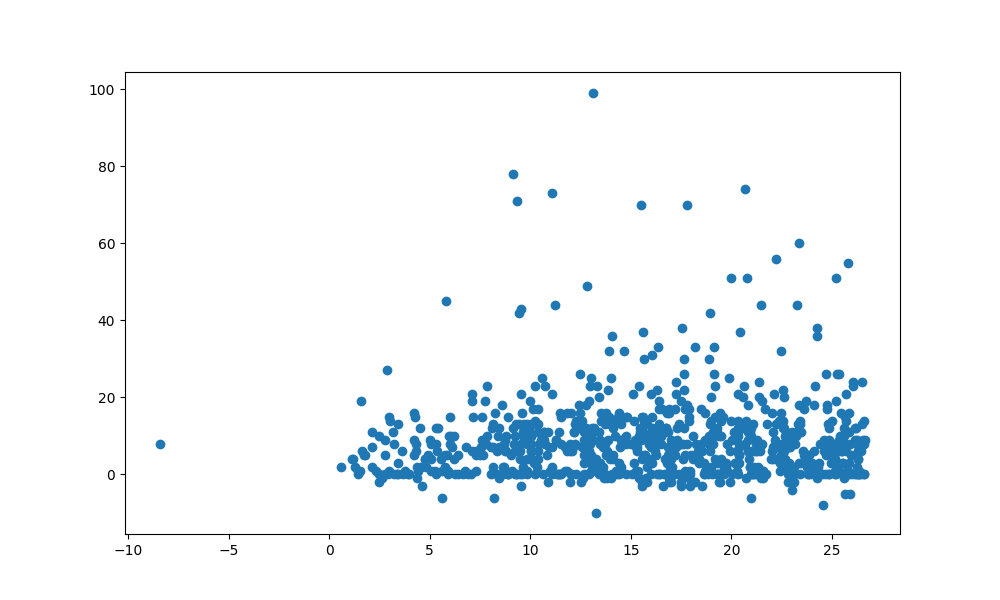

In [66]:
punt_received_football_only_df = punt_tracking_2018_df[
    (punt_tracking_2018_df[COLUMN.PLAY_EVENT] == PLAY_EVENT.PUNT_RECEIVED)
    & (punt_tracking_2018_df[COLUMN.TEAM] == 'football')
]
x = punt_received_football_only_df[COLUMN.DISTANCE_FROM_SIDELINE]
y = punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE]
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x, y)
plt.show()

In [56]:
x.corr(y)

0.035468871186775344

In [57]:
punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE].mean()

8.923543689320388

In [69]:
punt_received_football_only_df['aboveAverageReturn'] = \
    punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE] > punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE].mean()
punt_received_football_only_df[[COLUMN.X, COLUMN.Y, COLUMN.DISTANCE_FROM_SIDELINE, COLUMN.KICK_RETURN_YARDAGE, 'aboveAverageReturn']]

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_5364/3917194774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  punt_received_football_only_df['aboveAverageReturn'] = \


,x,y,distanceFromSideline,kickReturnYardage,aboveAverageReturn
2893,72.61,39.18,14.12,5.0,False
12741,91.77,35.94,17.36,8.0,False
17550,82.02,42.04,11.26,9.0,True
29543,30.37,32.33,20.97,12.0,True
32758,36.61,44.87,8.43,-1.0,False
36013,98.16,52.11,1.19,4.0,False
39204,41.47,38.14,15.16,3.0,False
43423,79.88,28.12,25.18,51.0,True
46369,80.46,23.87,23.87,1.0,False
60430,41.74,25.41,25.41,6.0,False


<IPython.core.display.Javascript object>


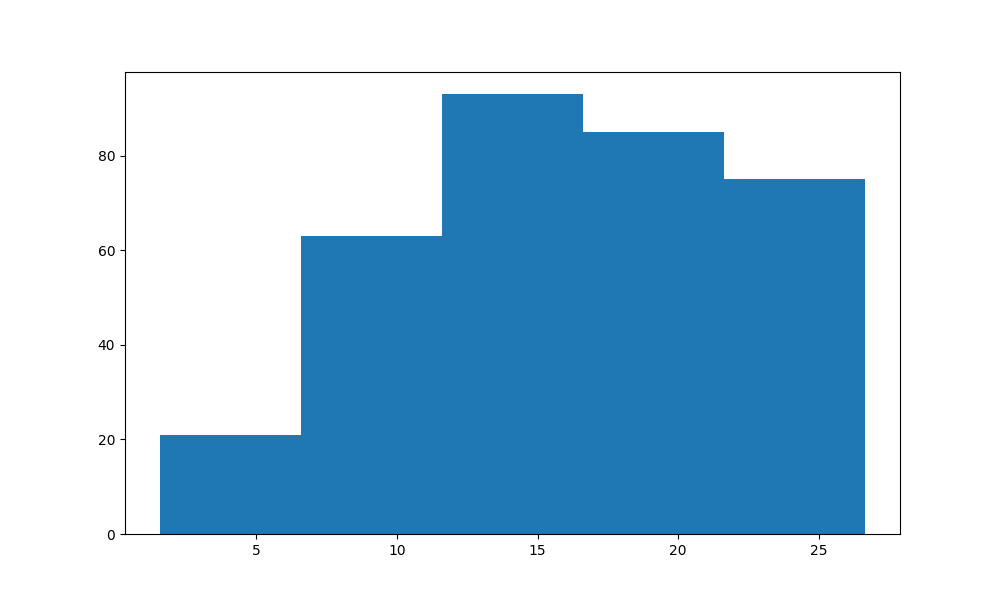

In [70]:
above_average_returns_df = punt_received_football_only_df[punt_received_football_only_df['aboveAverageReturn'] == True]
x = above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE]
bins = 5
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(x=x, bins=bins)
plt.show()

In [71]:
above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE].corr(above_average_returns_df[COLUMN.KICK_RETURN_YARDAGE])

0.04671642827966678

<IPython.core.display.Javascript object>


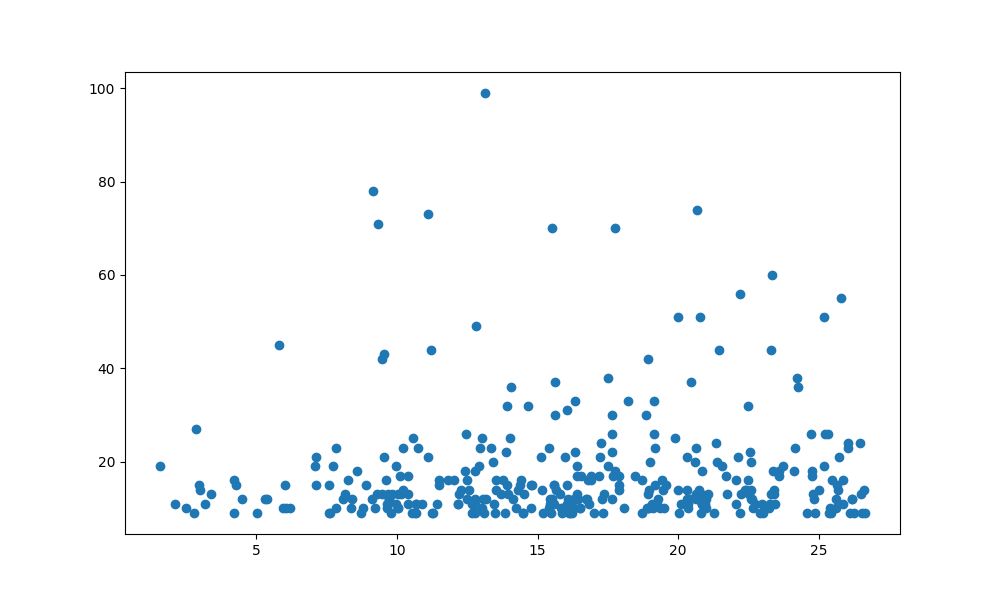

In [67]:
x = above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE]
y = above_average_returns_df[COLUMN.KICK_RETURN_YARDAGE]
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x, y)
plt.show()

In [72]:
# punt_tracking_2018_df.info()

In [54]:
punt_tracking_2018_df[COLUMN.PLAY_EVENT].unique()

array(['None', 'ball_snap', 'punt', 'punt_received', 'first_contact',
       'tackle', 'punt_land', 'touchback', 'fair_catch', 'punt_downed',
       'fumble', 'fumble_offense_recovered', 'fumble_defense_recovered',
       'out_of_bounds', 'punt_muffed', 'line_set', 'kick_received',
       'punt_blocked', 'man_in_motion', 'penalty_flag', 'touchdown',
       'punt_play', 'huddle_start_offense', 'handoff', 'punt_fake',
       'pass_forward', 'pass_outcome_incomplete', 'play_action',
       'pass_arrived', 'pass_outcome_caught', 'kick_recovered', 'lateral',
       'snap_direct', 'run', 'safety', 'huddle_break_offense',
       'kickoff_land'], dtype=object)

In [ ]:
'''
Predict punt landing position based on pre-snap inputs (ball position)

Inputs:
  - Positions of all players and ball at time of snap (22 players + ball, x and y positions)
Outputs:
  - Ball landing position x, y
  
TODO:
  - Stack all 3 years of data
  - For inputs, filter tracking data to play event = ball_snap
  - For outputs, filter to football position when play event is one of punt_received, punt_land,
    touchback, fair_catch, out_of_bounds, punt_muffed (validate these events)
  - Partition/sync inputs and outputs based on game id and play id
  - Partition data into training data and test data (80/20)
  - Use sklearn.linear_model.LogisticRegression to train and test
  - Visualize results
'''
